In [29]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); 
Pkg.instantiate()

using ForwardDiff
using LinearAlgebra
using Statistics
using Plots
plotlyjs()
using Printf
using Random
using DifferentialEquations

  Activating project at `~/Desktop/Work/Courses/OCRL-Walker-Project/juliaImplementation/juliaImplementation`


In [30]:
const FD = ForwardDiff;

PLOTS_DEFAULTS = Dict(:dpi => 600);

include("GeneralizedFunctionality/est_parameters.jl");
include("GeneralizedFunctionality/hybrid_system_simulation_tools.jl")
include("GeneralizedFunctionality/SKF_general.jl")
include("GeneralizedFunctionality/batch_estimation.jl")
include("GeneralizedFunctionality/generalized_saltation_calculations.jl")
include("DynamicSystems/bouncing_ball.jl") # Defines hybrid system functions
include("DynamicSystems/biped.jl") # Defines hybrid system functions

#Falling ball system definition
# dynamics = [balldynamics,balldynamics]
dynamics = [biped_dynamics_3link,biped_dynamics_2link]
resets = [[idReset,kneeReset],[heelReset,idReset]]
guards = [[idGuard,kneeGuard],[heelGuard,idGuard]]

2-element Vector{Vector{Function}}:
 [idGuard, kneeGuard]
 [heelGuard, idGuard]

In [31]:
#Definining initial states
mode0 = 1
# Σ = Diagonal([0.05,0.05,0.001,0.001])*1
Σ = Diagonal([0.05,0.05,0.001,0.001,1,1])*0
# xmean = [0.0,3.0,0.5,-5.0]

q1 = 0.1877
q2 = -0.2884
q3 = q2
q̇1 = -1.1014
q̇2 = -0.0399
q̇3 = q̇2

xmean = [q1, q2, q3, q̇1, q̇2, q̇3]

#Simulation times
t = 1.0 #10
dt = .01 #.1

#noise and measurement parameters
W = Diagonal([1.0,1.0,1.0,1.0,1,1])*0
V = Diagonal([1.0,1.0,1])*0
C = [I zeros(3,3)]

#structure of all this
param = ESTParameters(C,V,W,dt,dynamics,resets,guards)

ESTParameters([1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 0.01, Function[biped_dynamics_3link, biped_dynamics_2link], Vector{Function}[[idReset, kneeReset], [heelReset, idReset]], Vector{Function}[[idGuard, kneeGuard], [heelGuard, idGuard]])

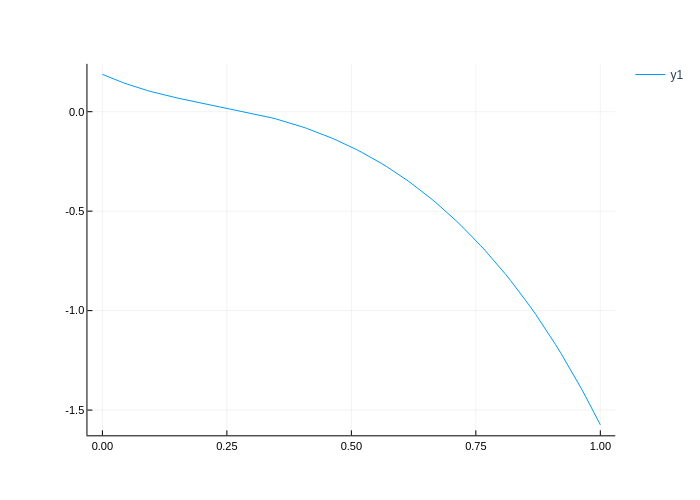

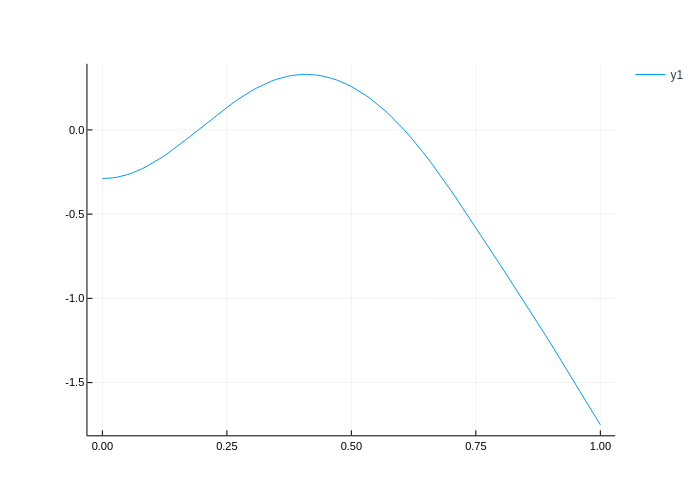

In [36]:
#Nominal Trajectory
nom_states, times, _, nom_modes,nom_impact_states,_ = sim_system(xmean,mode0,dynamics,resets,guards,W*.000000000000001,V,C,t,dt)

plot(0:dt:t,[state[1] for state in nom_states])
display(plot!())
plot(0:dt:t,[state[2] for state in nom_states])
display(plot!())

In [ ]:
# #Noisy Trajectory & Single Kalman Filter Solve
# Random.seed!(1) # get a trial consistently
# xstart = xmean + sqrt(Σ)*randn(size(xmean))

# states, measurements = sim_system(xstart,mode0,dynamics,resets,guards,W,V,C,t,dt)
# est_states, _ = skf(param,xmean,Σ,mode0,measurements)
# plot([state[1] for state in states],[state[2] for state in states],label="Ground Truth")
# plot!([state[1] for state in est_states],[state[2] for state in est_states],label="SKF Estimate")
# scatter!([meas[1] for meas in measurements],[meas[2] for meas in measurements],label="measurements")
# display(plot!())

# # Multiple Trials for SKF:
# iters = 10
# random_seed = 3

# avg_err, avg_step_err, avg_error, avgTime, step_err_kf = runMultipleKF(dynamics,resets,guards,W,V,C,xmean,Σ,mode0,t,dt;num_iters=iters,randseed=random_seed);

# display(plot(avg_step_err))